# Song Lyrics Generation By genre- Preprocessing #


##preprocessing:


imports:

In [ ]:
import torch
import pandas as pd
from google.colab import drive
import nltk
import matplotlib.pyplot as plt
import numpy as np
import random
import re


random.seed(123)  # set seeds for consistancy
np.random.seed(123)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # if using GPU

loading the data:

In [ ]:
# mount drive
drive.mount('/content/drive')

# define path to folder - CHANGE TO WHICHEVER DIRECTORY YOU WANT
path_folder = "/content/drive/MyDrive/Deep_Learning_2024/project"

FILENAME = path_folder+'/ds.csv'

Mounted at /content/drive


In [ ]:
#loading dataset:
df = pd.read_csv(FILENAME)

print("Dataset:")
print("Number of rows:", len(df))
print("Missing values:")
print(df.isnull().sum())

Dataset:
Number of rows: 5913411
Missing values:
title        452
tag            0
artist         0
year           0
views          0
features       0
lyrics      2345
id             0
dtype: int64


In [ ]:
print("Head of the dataset:")
print(df.head())

Head of the dataset:
               title  tag     artist  year   views  \
0          Killa Cam  rap    Cam'ron  2004  173166   
1         Can I Live  rap      JAY-Z  1996  468624   
2  Forgive Me Father  rap   Fabolous  2003    4743   
3       Down and Out  rap    Cam'ron  2004  144404   
4             Fly In  rap  Lil Wayne  2005   78271   

                                       features  \
0                   {"Cam\\'ron","Opera Steve"}   
1                                            {}   
2                                            {}   
3  {"Cam\\'ron","Kanye West","Syleena Johnson"}   
4                                            {}   

                                              lyrics  id  
0  [Chorus: Opera Steve & Cam'ron]\nKilla Cam, Ki...   1  
1  [Produced by Irv Gotti]\n\n[Intro]\nYeah, hah,...   3  
2  Maybe cause I'm eatin\nAnd these bastards fien...   4  
3  [Produced by Kanye West and Brian Miller]\n\n[...   5  
4  [Intro]\nSo they ask me\n"Young boy\nWhat you ...

As we can see, we have missing values ​​on "lyrics" column, thus we need to clean them.
Furthermore, we need only genre "rap" and "pop", thus we will clean other genres.

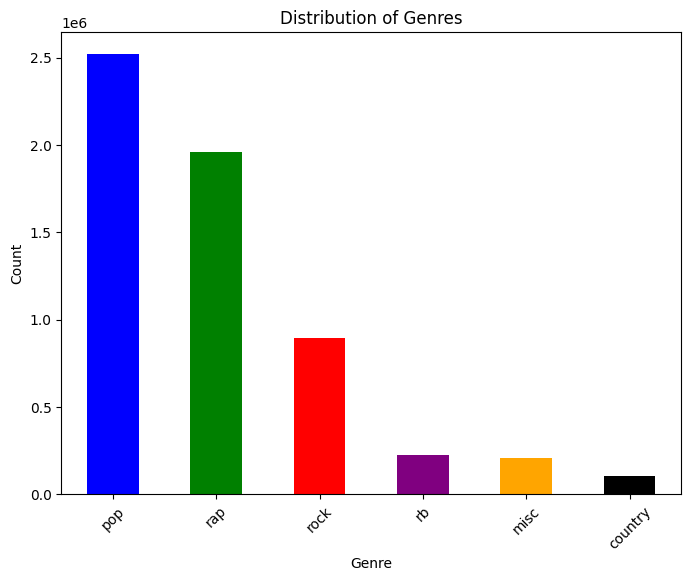

In [ ]:
# count the occurrences of each genre
genre_counts = df['tag'].value_counts()

# plot the distribution
plt.figure(figsize=(8, 6))
genre_counts.plot(kind='bar', color=['blue', 'green', 'red', 'purple', 'orange','black'])
plt.title('Distribution of Genres')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# function that deletes words that are not in English (we saw a song in Hebrew, etc...)
def Only_English(text):
    # Check if the text contains only English characters
    if isinstance(text, str):
        return text.isascii()
    else:
        return False

In [ ]:
# cleaning empty data cells on "lyrics" column
df = df.dropna(subset=['lyrics'])

print("Missing values in dataset 2 after cleaning:")
print(df.isnull().sum())

#print the size of the dataset after cleaning
print("Number of rows: after cleaning:", len(df))

Missing values in dataset 2 after cleaning:
title       391
tag           0
artist        0
year          0
views         0
features      0
lyrics        0
id            0
dtype: int64
Number of rows: after cleaning: 5911066


In [ ]:
#filter out rows with genres other than "rap" and "pop"
df = df[df['tag'].isin(['rap', 'pop'])]

print("\nSize of Filtered Dataset:", len(df))

tags = df['tag'].unique()
print("Unique values in the 'tag' column:")
print(tags)
print("\nNumber of unique values in the 'tag' column:", len(tags))


Size of Filtered Dataset: 4480364
Unique values in the 'tag' column:
['rap' 'pop']

Number of unique values in the 'tag' column: 2


In [ ]:
#keep only the columns that match the first Dataset
columns_to_keep = ['tag', 'lyrics']

# Drop columns except 'tag' and 'lyrics'
df = df[columns_to_keep]

df.reset_index(drop=True, inplace=True)

# Show the resulting dataset
print("Dataset after removing columns except 'tag' and 'lyrics':")
print(df.head())

Dataset after removing columns except 'tag' and 'lyrics':
   tag                                             lyrics
0  rap  [Chorus: Opera Steve & Cam'ron]\nKilla Cam, Ki...
1  rap  [Produced by Irv Gotti]\n\n[Intro]\nYeah, hah,...
2  rap  Maybe cause I'm eatin\nAnd these bastards fien...
3  rap  [Produced by Kanye West and Brian Miller]\n\n[...
4  rap  [Intro]\nSo they ask me\n"Young boy\nWhat you ...


In [ ]:
# rename'lyrics' column to 'lyric'
df.rename(columns={'lyrics': 'lyric'}, inplace=True)

# replace 'tag' column to 'class' with numeric values- 0/1: rap=0, pop=1.
df['class'] = df['tag'].apply(lambda x: 1 if x == 'pop' else 0)

<ipython-input-10-12162df32863>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'lyrics': 'lyric'}, inplace=True)


In [ ]:
#drop the 'tag' column
df.drop(columns=['tag'], inplace=True)

print(df.head())
print("The updated dataset:", len(df))

                                               lyric  class
0  [Chorus: Opera Steve & Cam'ron]\nKilla Cam, Ki...      0
1  [Produced by Irv Gotti]\n\n[Intro]\nYeah, hah,...      0
2  Maybe cause I'm eatin\nAnd these bastards fien...      0
3  [Produced by Kanye West and Brian Miller]\n\n[...      0
4  [Intro]\nSo they ask me\n"Young boy\nWhat you ...      0
The updated dataset: 4480364


In [ ]:
def cleaning_specific_data(lyrics):
    non_lyrical_keywords = ['instrumental', 'loading...', 'save cancel'] # specific keywords indicating non-lyrical content

    # checking if any of the non-lyrical keywords in the lyrics
    for keyword in non_lyrical_keywords:
        if keyword in lyrics.lower(): # convert lyrics to lowercase for case-insensitive matching
            return None # return None because the song should be deleted

    # none of the non-lyrical keywords are found, return the lyrics
    return lyrics


In [ ]:
def cleaning_specific_data2(lyrics):
  lyrics = re.sub(r'\[[^\]]*\]|\([^\)]*\)|\{[^}]*\}', '', lyrics) # remove (){}[] and words between
  lyrics = re.sub(r'[{}()\[\]<>]', '', lyrics) # remove stand alone (,),{,},[,]
  lyrics = re.sub(r'http\S+', '', lyrics) # remove links
  lyrics = re.sub(r'@\w*', '', lyrics) # remove @user
  lyrics = re.sub(r'#\w*', '', lyrics) # remove #hashtag
  lyrics = re.sub(r'\d+', '', lyrics) # remove numbers
  lyrics = re.sub(r'[*\-+=]', '', lyrics) # remove *, -, +, =

  return lyrics

In [ ]:
df.head() #before cleaning [],(),{}...

,lyric,class
0,"[Chorus: Opera Steve & Cam'ron]\nKilla Cam, Ki...",0
1,"[Produced by Irv Gotti]\n\n[Intro]\nYeah, hah,...",0
2,Maybe cause I'm eatin\nAnd these bastards fien...,0
3,[Produced by Kanye West and Brian Miller]\n\n[...,0
4,"[Intro]\nSo they ask me\n""Young boy\nWhat you ...",0


In [ ]:
for i, row in df.iterrows():
  orig = row['lyric']
  clean_line = cleaning_specific_data2(orig)
  df.at[i,'lyric'] = clean_line

In [ ]:
df.head() # after the cleaning

,lyric,class
0,"\nKilla Cam, Killa Cam, Cam\nKilla Cam, Killa ...",0
1,"\n\n\nYeah, hah, yeah, RocAFella\nWe invite yo...",0
2,Maybe cause I'm eatin\nAnd these bastards fien...,0
3,"\n\n\nUgh, Killa!\nBaby!\nKanye, this that s H...",0
4,"\nSo they ask me\n""Young boy\nWhat you gon' do...",0


In [ ]:
# filter out non-English lyrics of dataset:
df = df[df['lyric'].apply(Only_English)].reset_index(drop=True)

print("Size of dataset after filtering non-English lyrics:", len(df))

Size of dataset after filtering non-English lyrics: 2099797


In [ ]:
# cheking the model

df_rap = df[df['class'] == 0]
df_pop = df[df['class'] == 1]

print("Size of df_rap:", len(df_rap))
print("Size of df_pop:", len(df_pop))

print(df_rap.head())
print(df_pop.head())

Size of df_rap: 699566
Size of df_pop: 1400231
                                               lyric  class
0  \nKilla Cam, Killa Cam, Cam\nKilla Cam, Killa ...      0
1  Maybe cause I'm eatin\nAnd these bastards fien...      0
2  \nSo they ask me\n"Young boy\nWhat you gon' do...      0
3  \nNo, no, no!\nI told you, I lived this shit\n...      0
4  \nAy yo you wonder who I are\nI guzzle up at t...      0
                                                 lyric  class
212  \nIn December, drinking horchata\nI'd look psy...      1
304  \nFlashing lights \nFlashing lights \nFlashing...      1
316  \n\n\nOh, woah\nOh, woah\nOh, woah\n\n\nYou kn...      1
426  \nI feel like I wanna smack somebody\nTurn aro...      1
441  \nI see you drivin' 'round town with the girl ...      1


In [ ]:
def add_genre_tags(row):
    if row['class'] == 1:
        return '[Genre: Pop] ' + row['lyric']
    elif row['class'] == 0:
        return '[Genre: Rap] ' + row['lyric']
    # else:
    #     return row['lyric']

In [ ]:
# apply the function to each row
df['lyric'] = df.apply(add_genre_tags, axis=1)
print(df.head())

                                               lyric  class
0  [Genre: Rap] \nKilla Cam, Killa Cam, Cam\nKill...      0
1  [Genre: Rap] Maybe cause I'm eatin\nAnd these ...      0
2  [Genre: Rap] \nSo they ask me\n"Young boy\nWha...      0
3  [Genre: Rap] \nNo, no, no!\nI told you, I live...      0
4  [Genre: Rap] \nAy yo you wonder who I are\nI g...      0


Save dataset after cleaning:

In [ ]:
file_path = '/content/drive/MyDrive/Deep_Learning_project/ds_clean.csv'
df.to_csv(file_path, index=False)